Allison Aprile

CPE645 Final Project

Dog Camera - Method Exploration 

# Artificial Neural Network (ANN) 
* Simulates learning process for decision making
* Neural networks contain connected nodes, which a weight associated with each connection
* Many possible architectures/algorithms, including fully convolutional networks, graph convolutional models, encoder-decoder models, recurrent neural networks, attention-based models, and other models
  - Convolutional models are SOTA in current computer vision tasks because convolutional filters good for feature extraction, as discussed in class (principles of 2-D DSP)
  - Standard CNN model performance depends heavily on size of training data and network size
* Useful for separating object(s) from background 
* Unlike other techniques, requires class labels and training a model
* **Semantic Segmentation**: classifying each pixel as a certain class (localization)
  - Requires pixel-level labels
  - Because common task in medical industry, looked for architectures more aligned with such

* In 2015, the U-Net Convolutional Neural Network architecture was introduced for biomedical image segmentation
  - Builds on 'full' CNN architecture 
  - Relies on data augmentation; model learns anomalies without being explicit in training data - important for deformaties in biomedical industries, but also with new mixes of dogs and various environment factors (rotated camera, lighting, etc.) 
  - Architecture innovation: contracting path to capture context and a symmetric expanding path that enables precise localization
    - Usual contracting network with successive layers; typical architecture of CNN (repeated application of two 3x3 convolutions, followed by rectified linear unit and 2x2 pooling operation with stride 2 for downsampling. Double number of feature channels at each downsampling step
    - Every step in expansive path consists of upsampling of feature map followedd by 2x2 convolution that halves the number of feature channels, a concatenation of feature maps, additional 3x3 convolutions with relu activation. 1x1 convolution at end maps 64-component feature vector to number of classes
    - Total of 23 Convolutional blocks
    - Important that input tile size yields even x and y size for layers with 2x2 max pooling operations (selected 160)
    - Replaced pooling operators with upsampling operators to increase resolution of output --> high resolution features are necessary for good localization
    - Combine high resolution features with upsampled output, so next convolutional layer can learn to assemble a more precise output
    - Important modification: large number of feature channels in upsampling part, allowing network to propagate context to higher resolution layers (causes u-shaped architecture)
    - No fully connected layers and overlap tiling strategy --> important for larger images, otherwise resolution would limit GPU memory
  - Can be effectively trained on smaller neural networks
    - Because semantic labeling is tedious task, revolutionary
  - Outperforms prior best method of sliding-window CNN)
    - Old method is slow because must be run separately for each window patch, and redundancy due to overlapping patches
    - Trade-off between localization accuracy and use of context
  - Fast on GPU --> Ideal for real-time video semgentation  
  - Favor large input tiles over a large batch size in training (reduce batch to single image); minimizes overhead 
  - Energy function is a pixel-wise softmax over final feature map combined with cross entropy loss function 
  - Won with a large margin on the two most challenging 2D transmitted light datasets 


## Dog Semantic Segmentation
* Using Oxford-IIIT Pets dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/)
  - 160x160p images spanning 37 categories of different dog and cat breeds
  - Images have variatiion in scale, pose, and lighting 
  - Annotated with species and breed name, tight bounding box (Region-of-Interest) around animal head, and pixel-level foreground-background segmentation 
    - Pixel-level segmentations are trimap: foreground (pet body), background, and ambiguous (the pet body boundary and any accessory such as collars)
  - Process for DOGS only: my dataset will contain 4978 images of dogs spanning 25 different breeds 

* Loosely following (https://keras.io/examples/vision/oxford_pets_image_segmentation/) for architecture and training steps


In [ ]:
# For use with Raspberry Pi, need to downgrade TensorFlow
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.1 kB/s 
     |████████████████████████████████| 2.9 MB 34.2 MB/s 
     |████████████████████████████████| 3.0 MB 51.5 MB/s 
     |████████████████████████████████| 454 kB 49.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import PIL
import re
import random
from tensorflow import keras 
from tensorflow.keras.layers import add, Conv2D, BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D 
from tensorflow.keras import Model
import numpy as np

### Data Preprocessing

In [ ]:
# Download data
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  30.0M      0  0:00:25  0:00:25 --:--:-- 31.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  6210k      0  0:00:03  0:00:03 --:--:-- 6210k


In [ ]:
# Unpack data
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
# Organize files
img_size = (160, 160)
num_classes = 3 # Foreground, background, and ambiguous 
batch_size = 32 # In paper, suggested use 1 image per batch; however, small training data in this case

# Images
input_files = sorted(
    [os.path.join('images/', image) 
    for image in os.listdir('images/') if image.endswith('.jpg')])

# Masks
target_files = sorted(
    [os.path.join('annotations/trimaps/', mask)
    for mask in os.listdir('annotations/trimaps/') if mask.endswith('.png')
    and not mask.startswith('.')]
)

In [ ]:
# Confirm download
print('Total number of samples: ', len(input_files))
for i in range(5):
  print(input_files[i], target_files[i])

Total number of samples:  7390
images/Abyssinian_1.jpg annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg annotations/trimaps/Abyssinian_102.png


In [ ]:
# Get breed list of only dogs
breeds = [i.split('/')[-1].replace('.jpg', '') for i in input_files]
breeds = set([re.sub(r'_[0-9]+', '', b) for b in breeds])
dogs = [b for b in breeds if b[0].islower()] # Dog photos start with lowercase letter; cats with uppercase

In [ ]:
# Check with list (https://www.robots.ox.ac.uk/~vgg/data/pets/)
sorted(dogs)

['american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [ ]:
# Remove cats from dataset
dog_images = [i for i in input_files if any(d in i for d in dogs)]
dog_masks = [i for i in target_files if any(d in i for d in dogs)]

# Confirm - check that each image has corresponding mask
[j.split('/')[-1].replace('.jpg', '') for j in dog_images] == [k.split('/')[-1].replace('.png', '') for k in dog_masks] 

True

(160, 160, 3)


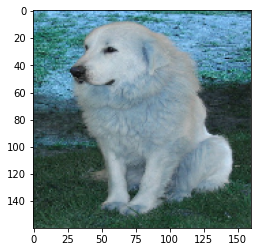

(160, 160, 3)


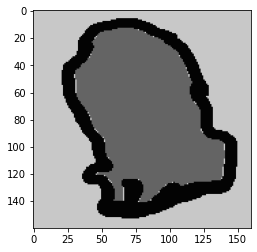

In [ ]:
# Display test input image and corresponding ground truth mask
img = cv2.imread(dog_images[1800])
img = cv2.resize(img, img_size)
plt.imshow(img)
print(img.shape)

plt.show()

mask = cv2.imread(dog_masks[1800])
mask = cv2.resize(mask, img_size)
print(mask.shape)
mask[mask == 1] = 100
mask[mask == 2] = 200
plt.imshow(mask)
plt.show()

In [ ]:
# Randomly sample 10% of images for validation set
validation_ind = random.sample(list(range(len(dog_images))), int(len(dog_images)*0.1))
train_ind = list(set(list(range(len(dog_images)))) - set(validation_ind))

train_img = [dog_images[i] for i in train_ind]
train_masks = [dog_masks[i] for i in train_ind]
val_img = [dog_images[i] for i in validation_ind]
val_masks = [dog_masks[i] for i in validation_ind]

# Report number of samples
print('Total samples: ', len(dog_images))
print('Training: ', len(train_img))
print('Validation: ', len(val_img))

# Confirm split
print(len(train_img) == len(train_masks))
print(len(val_img) == len(val_masks))

Total samples:  4990
Training:  4491
Validation:  499
True
True


In [ ]:
# Prepare Sequence class to load & vectorize batches of data
class OxfordDogs(kt.utils.Sequence):
  # Initialization
  def __init__(self, batch_size, img_size, img_paths, mask_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_paths = img_paths
    self.mask_paths = mask_paths

  # Gets number of iterations per epoch
  def __len__(self):
    return len(self.mask_paths) // self.batch_size

  def __getitem__(self, ind):
    # Returns tuple (input, target) corresponding to batch number index
    i = ind * self.batch_size
    batch_img_paths = self.img_paths[i : i + self.batch_size]
    batch_mask_paths = self.mask_paths[i : i + self.batch_size]

    # Initialize 
    x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype = 'float32')

    # Load and process input images
    for j, path in enumerate(batch_img_paths):
      img = cv2.imread(path)
      img = cv2.resize(img, self.img_size)
      x[j] = img

    # Initialize
    y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype = 'uint8')

    # Load and process masks
    for j, path in enumerate(batch_mask_paths):
      mask = cv2.imread(path, 0)
      mask = cv2.resize(mask, self.img_size)
      y[j] = np.expand_dims(mask, 2)

    # Map values back to [0, 1, 2]
    y -= 1
    
    return x, y

In [ ]:
# Instantiate data sequences for training and validation sets
train_data = OxfordDogs(batch_size, img_size, train_img, train_masks)
val_data = OxfordDogs(batch_size, img_size, val_img, val_masks)

### Define model architecture

In [ ]:
# Define U-Net Xception model architecture
input = keras.Input(shape = img_size + (3, ))

### First half of network - downsampling inputs
# Entry block
x = Conv2D(32, 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Set aside residual
previous_block_activation = x

# Convolution blocks: Three 3x3 convolutional filters followed by 2x2 Max Pooling operation
for filters in [64, 128, 256]:
  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding = 'same')(x)
  x = BatchNormalization()(x)

  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding = 'same')(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(3, strides = 2, padding = 'same')(x) # Stride = 2 for downsampling

  # Project residual
  residual = Conv2D(filters, 1, strides = 2, padding = 'same')(previous_block_activation)

  # Add back residual
  x = add([x, residual])

  # Set aside next residual
  previous_block_activation = x


### Second half of network - upsampling feature maps
# Two 2x2 convolutional filters to half the number of feature channels
for filters in [256, 128, 64, 32]:
  x = Activation('relu')(x)
  x = Conv2DTranspose(filters, 3, padding = 'same')(x)
  x = BatchNormalization()(x)

  x = Activation('relu')(x)
  x = Conv2DTranspose(filters, 3, padding = 'same')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(2)(x)

  # Project residual
  residual = UpSampling2D(2)(previous_block_activation)
  residual = Conv2D(filters, 1, padding = 'same')(residual)

  # Add back residual - concatenation of feature maps
  x = add([x, residual])

  # Set aside next residual
  previous_block_activation = x


### Per-pixel classification layer: 1x1 convolutional layer to map 64-dimensional vector to 3 classes
output = Conv2D(num_classes, 3, activation = 'softmax', padding = 'same')(x)

### Build the model
model = Model(input, output)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Model Training

In [ ]:
# Free up RAM
keras.backend.clear_session()

In [ ]:
### Model training
# Compile model with RMS prop optimizer and Sparse Categorical Cross Entropy loss (faster, adaptive learning rate, sparse better for segmentation tasks)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Define callbacks (ensures model saving)
callbacks = [keras.callbacks.ModelCheckpoint("dog_segmentation.h5", save_best_only=True)]

# Train the model
history = model.fit(train_data, epochs = 10, validation_data = val_data, callbacks=callbacks)

Epoch 1/10
140/140 [==============================] - 29s 210ms/step - loss: 1.2113 - val_loss: 2.7314
Epoch 2/10
140/140 [==============================] - 29s 205ms/step - loss: 0.5888 - val_loss: 2.3974
Epoch 3/10
140/140 [==============================] - 29s 208ms/step - loss: 0.4885 - val_loss: 1.9734
Epoch 4/10
140/140 [==============================] - 29s 204ms/step - loss: 0.4375 - val_loss: 0.4578
Epoch 5/10
140/140 [==============================] - 29s 205ms/step - loss: 0.4005 - val_loss: 0.4626
Epoch 6/10
140/140 [==============================] - 29s 204ms/step - loss: 0.3677 - val_loss: 0.4108
Epoch 7/10
140/140 [==============================] - 29s 204ms/step - loss: 0.3386 - val_loss: 0.3893
Epoch 8/10
140/140 [==============================] - 28s 202ms/step - loss: 0.3132 - val_loss: 0.3908
Epoch 9/10
140/140 [==============================] - 28s 201ms/step - loss: 0.2946 - val_loss: 0.4269
Epoch 10/10
140/140 [==============================] - 28s 200ms/step - l

### Evaluation

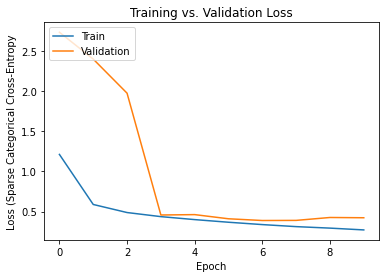

In [ ]:
# Plot training vs. validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss (Sparse Categorical Cross-Entropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
### Visualize predictions
# Define function to view mask
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)

  mask[mask == 1] = 100
  mask[mask == 2] = 200
  plt.imshow(mask)
  plt.show()

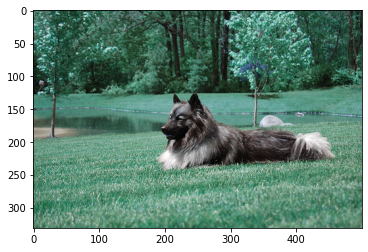

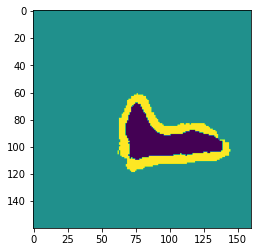

In [ ]:
# Get validation predictions
val_preds = model.predict(val_data)

# Display result
plt.imshow(cv2.imread(val_img[10]))
plt.show()

display_mask(val_preds[10])

In [ ]:
# Mount drive for testing images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load testing files
test1 = cv2.imread('/content/drive/My Drive/Dog Camera/Dog Camera/test1.JPG')
test2 = cv2.imread('/content/drive/My Drive/Dog Camera/Dog Camera/test2.JPG')
test3 = cv2.imread('/content/drive/My Drive/Dog Camera/Dog Camera/test3.JPG')
test4 = cv2.imread('/content/drive/My Drive/Dog Camera/Dog Camera/test4.JPG')
test5 = cv2.imread('/content/drive/My Drive/Dog Camera/Dog Camera/test5.JPG')

In [ ]:
# Define mask prediction function
def get_dog_mask(img):
  # Reshape/make into a 'batch' to fit classifier
  x = np.zeros((1, ) + (160, 160) + (3, ), dtype = 'float32')
  img_resized = cv2.resize(img, (160, 160))
  x[0] = img_resized

  # Make prediction
  pred = model.predict(x)

  # Define mask
  mask = np.argmax(pred[0], axis=-1).astype('float32')
  mask[mask == 1] = 100
  mask[mask == 2] = 200
  mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))

  # Plot
  plt.imshow(img)
  plt.show()
  plt.imshow(mask_resized)
  plt.show()
  return mask

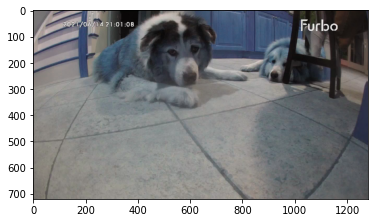

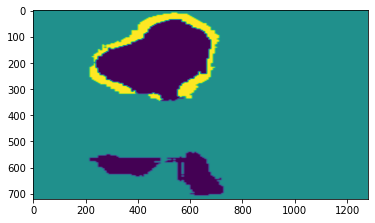

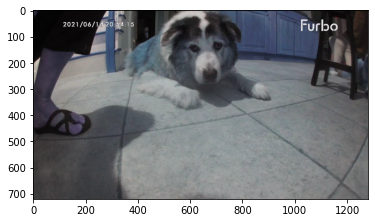

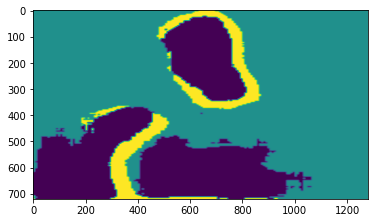

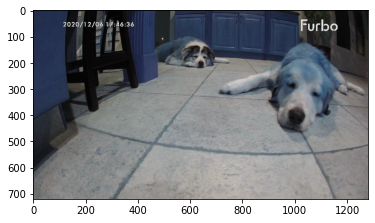

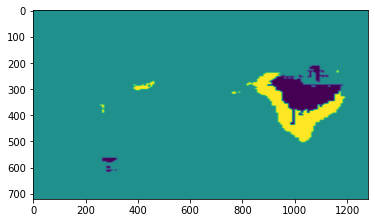

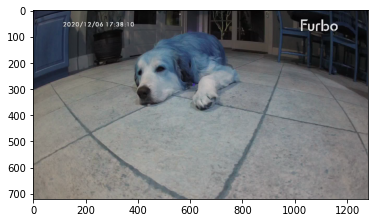

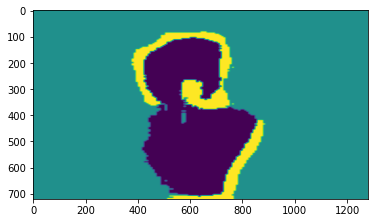

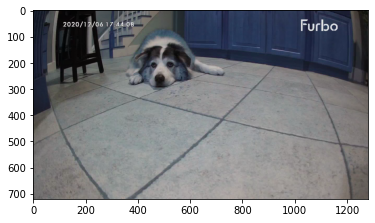

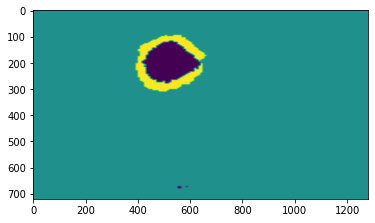

In [ ]:
# Show test results
for t in [test1, test2, test3, test4, test5]:
  mask = get_dog_mask(t)

In [ ]:
# Save model
keras.models.save_model(model, '/content/drive/My Drive/Aprile_CPE695_Final_Project/dog_seg_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/dog_seg_model/assets


In [ ]:
# Test model loading
mod = keras.models.load_model('/content/drive/My Drive/Aprile_CPE695_Final_Project/dog_seg_model')

In [ ]:
mod.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________